In [1]:
#import packages
import datetime as dt
import numpy as np
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.feature
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import xarray as xr
import scipy.stats
import pickle

#import statements for the clustering-related portions
from sklearn.cluster import KMeans as km

In [2]:
#open files for split gph data and recombine
infile = open("../../New_ERAfiles/gph_NEW.p", 'rb')
gph = pickle.load(infile)
infile.close()

infile = open("../../New_ERAfiles/gph_time_NEW.p", 'rb')
gph_time = pickle.load(infile)
infile.close()

infile = open("../../New_ERAfiles/gph_lat_NEW.p", 'rb')
gph_lat = pickle.load(infile)
infile.close()

infile = open("../../New_ERAfiles/gph_lon_NEW.p", 'rb')
gph_lon = pickle.load(infile)
infile.close()

In [3]:
gph.shape

(12160, 128, 512)

In [4]:
#non-stacked
gph = xr.DataArray(data= gph, 
                       dims = ["time","lat","lon"],
                       coords = dict(
                           time = gph_time,
                           lat = gph_lat,
                           lon = gph_lon)
                      )

In [5]:
gph

<xarray.DataArray (time: 12160, lat: 128, lon: 512)>
array([[[30955.646, 30957.584, 30959.674, ..., 30953.146, 30953.3  ,
         30954.115],
        [30956.615, 30958.756, 30960.947, ..., 30953.3  , 30953.709,
         30954.78 ],
        [30957.584, 30959.775, 30962.02 , ..., 30953.402, 30954.115,
         30955.492],
        ...,
        [29367.795, 29367.387, 29366.928, ..., 29369.018, 29368.611,
         29368.203],
        [29356.883, 29356.578, 29356.322, ..., 29357.648, 29357.393,
         29357.139],
        [29347.91 , 29347.809, 29347.654, ..., 29348.268, 29348.113,
         29348.012]],

       [[30927.26 , 30926.953, 30926.24 , ..., 30926.393, 30927.209,
         30927.463],
        [30926.648, 30926.342, 30925.781, ..., 30926.086, 30926.7  ,
         30926.852],
        [30925.576, 30925.168, 30924.812, ..., 30925.781, 30925.883,
         30925.781],
...
        [29473.12 , 29473.68 , 29474.24 , ..., 29471.588, 29472.098,
         29472.61 ],
        [29501.16 , 29501.467, 29501.824, ..., 29500.191, 29500.498,
         29500.803],
        [29530.63 , 29530.783, 29530.936, ..., 29530.223, 29530.324,
         29530.477]],

       [[30907.75 , 30908.31 , 30909.28 , ..., 30905.354, 30906.578,
         30907.24 ],
        [30905.1  , 30905.762, 30906.73 , ..., 30902.703, 30903.621,
         30904.334],
        [30902.295, 30903.06 , 30903.824, ..., 30900.459, 30900.918,
         30901.428],
        ...,
        [29456.133, 29456.643, 29457.154, ..., 29454.654, 29455.113,
         29455.623],
        [29484.482, 29484.787, 29485.094, ..., 29483.564, 29483.87 ,
         29484.176],
        [29514.46 , 29514.562, 29514.717, ..., 29514.053, 29514.156,
         29514.309]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1999-11-01 ... 2019-04-01T18:00:00
  * lat      (lat) float32 1.0 0.9998 0.9995 0.9991 ... 0.03373 0.02152 0.009375
  * lon      (lon) float32 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3

In [6]:
gph_Day = gph.groupby('time.date').mean()

In [ ]:
##full_S = full_D.stack(mtime = ("metric","date"), latlon = ("lat","lon")) #stack lat and lon
gph_S2 = gph.stack(latlon = ("lat","lon")) #stack lat and lon
gph_S2

In [7]:
##full_S = full_D.stack(mtime = ("metric","date"), latlon = ("lat","lon")) #stack lat and lon
gph_S = gph_Day.stack(latlon = ("lat","lon")) #stack lat and lon
gph_S

<xarray.DataArray (date: 3040, latlon: 65536)>
array([[30936.018, 30936.082, 30936.018, ..., 29325.223, 29325.096,
        29324.996],
       [30912.352, 30913.55 , 30914.672, ..., 29252.445, 29252.395,
        29252.318],
       [30890.605, 30890.518, 30890.148, ..., 29180.416, 29180.389,
        29180.34 ],
       ...,
       [30941.088, 30942.312, 30942.795, ..., 29430.186, 29430.328,
        29430.492],
       [30951.553, 30950.863, 30950.164, ..., 29511.701, 29511.89 ,
        29512.045],
       [30940.375, 30941.18 , 30941.97 , ..., 29522.17 , 29522.283,
        29522.438]], dtype=float32)
Coordinates:
  * date     (date) object 1999-11-01 1999-11-02 ... 2019-03-31 2019-04-01
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 1.0 1.0 1.0 1.0 ... 0.009375 0.009375 0.009375
  - lon      (latlon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3

In [ ]:
inertia = []
clusters = np.arange(1,9,1) #testing number of clusters 
for n in clusters:
    #provides labels of clusters
    h_km = km(n_clusters = n).fit(gph_S2)
    #Getting unique labels
    h_labels = np.unique(h_km)
    h_inertia = h_km.inertia_
    inertia.append(h_inertia)

In [ ]:
%matplotlib inline
plt.title("Cluster Inertia Test")
plt.scatter(clusters,inertia)
plt.xlabel("N Clusters")
plt.ylabel("Cluster Inertia")
plt.show()

In [8]:
from sklearn.decomposition import PCA
 
pca = PCA(5)

In [9]:
test = pca.fit_transform(gph_S)

In [10]:
#plotting the results:
h_km = km(n_clusters = 5, random_state=0)
label = h_km.fit_predict(gph_S)
#Getting unique labels
h_labels = np.unique(label)

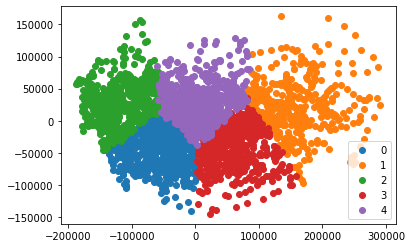

In [11]:
%matplotlib inline
for i in h_labels:
    plt.scatter(test[label == i , 0] , test[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
label

In [ ]:
pickle.dump(label, open("ALL_HOURLY_GPHcluster_labels.p", 'wb'))

In [ ]:
infile = open("UW_lat.p", 'rb')
unweighted_lat = pickle.load(infile)
infile.close()

infile = open("UW_lon.p", 'rb') 
unweighted_lon = pickle.load(infile)
infile.close()

In [ ]:
#initialize separation of four clusters
C1 = []
C2 = []
C3 = []
C4 = []
C5 = []

for k in range(len(label)):
    if label[k] == 0:
        C1.append("k")
    if label[k] == 1:
        #print(k)
        C2.append("k")
    if label[k] == 2:
        #print(k)
        C3.append("k")
    if label[k] == 3:
        #print(k)
        C4.append("k") 
    if label[k] == 4:
        #print(k)
        C5.append("k") 

print(len(C1))
print(len(C2))
print(len(C3))
print(len(C4)) 
print(len(C5)) 


In [ ]:
C1 = np.zeros((2185,128,512))
C2 = np.zeros((2456,128,512))
C3 = np.zeros((1895,128,512))
C4 = np.zeros((2935,128,512))
C5 = np.zeros((2689,128,512))

In [ ]:
#set the initial index for each empty array to 0 so it can increas with each aded value
index1 = 0
index2 = 0
index3 = 0
index4 = 0
index5 = 0

#loop, create clustered arrays, yay
for k in range(len(label)):
    if label[k] == 0:
        C1[index1,:,:] = gph[k,:,:]
        index1 = index1 + 1
        
    if label[k] == 1:
        C2[index2,:,:] = gph[k,:,:]
        index2 = index2 + 1
        
    if label[k] == 2:
        C3[index3,:,:] = gph[k,:,:]
        index3 = index3 + 1
        
    if label[k] == 3:
        C4[index4,:,:] = gph[k,:,:]
        index4 = index4 + 1
 
    if label[k] == 4:
        C5[index5,:,:] = gph[k,:,:]
        index5 = index5 + 1

In [ ]:
lat_index = unweighted_lat
lon_index = unweighted_lon

In [ ]:
h_cluster1 = xr.DataArray(data= np.mean(C1,axis=0), 
                       dims = ["lat","lon"],
                       coords = dict(
                           lat = lat_index,
                           lon = lon_index)
                      )

h_cluster2 = xr.DataArray(data= np.mean(C2,axis=0), 
                       dims = ["lat","lon"],
                       coords = dict(
                           lat = lat_index,
                           lon = lon_index)
                      )

h_cluster3 = xr.DataArray(data= np.mean(C3,axis=0), 
                       dims = ["lat","lon"],
                       coords = dict(
                           lat = lat_index,
                           lon = lon_index)
                      )

h_cluster4 = xr.DataArray(data= np.mean(C4,axis=0), 
                       dims = ["lat","lon"],
                       coords = dict(
                           lat = lat_index,
                           lon = lon_index)
                      )

h_cluster5 = xr.DataArray(data= np.mean(C5,axis=0), 
                       dims = ["lat","lon"],
                       coords = dict(
                           lat = lat_index,
                           lon = lon_index)
                      )

In [ ]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.colors
import matplotlib.cm

plt.Figure(figsize=(20,20),dpi=120)
ax = plt.axes(projection=ccrs.Orthographic(0,90))
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='dimgray',facecolor='none')
#ax.set_extent([-180,180,0,90],ccrs.PlateCarree())
ax.outline_patch.set_edgecolor('none')
gl = ax.gridlines(draw_labels=True,linewidth=1, color='black', alpha=0.5)
gl.xlabels_top = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}

ax.contourf(lon_index,lat_index,h_cluster5,transform=ccrs.PlateCarree(),cmap="bwr")

cmap = matplotlib.cm.bwr
norm = matplotlib.colors.Normalize(vmin = np.min(gph.values),vmax=np.max(gph.values))

cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location = 'right', shrink=0.6, pad=0.1) #add colorbar
#tick_locator = ticker.MaxNLocator(nbins=10)
#cbar.locator = tick_locator
#cbar.update_ticks()
cbar.set_label(label='Geopotential Height (m)', size=10)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout
plt.title("ERA-I 10hPa Geopotential Height, Cluster 5")
plt.savefig("ALL_HOURLY_ERAIgph_C5map.png")